In [ ]:
%cd "../"
%pwd

import numpy as np
import matplotlib.pyplot as plt

import io 
import pandas as pd  
import pyreadr

from load_data import *
from pred_score import *
from Filter_FS import *
from hybrid_FS import *
from overlap_genes import *
from crossValidation import *

In [ ]:
#Fixing seed to get reproducible results
random.seed(3)
np.random.seed(3)

# Baseline with preselected genes 

In [ ]:
#Load preprocess data
AE3= np.array(pd.read_csv ('../data/processed_data/AE3.csv'))
y = np.array(AE3[:,-1],dtype=int)
AE3 = AE3[:,0:-1]


In [ ]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(AE3,y)

In [ ]:
print(AE3.shape, len(pred))
acc = model.score_
print(acc, model.recovery)

In [ ]:
print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))

# Mutual information maximizer (MIM)

In [ ]:
#Define parameters for MIM method
N = np.arange(80,1500,30)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE3, FamiliesClusters, compute_precision,True, 5,  MIM, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_RI,True)
x_subset = AE3[:, subset]
pred = model.fit_predict(x_subset,y)

print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))

In [ ]:
get_best_genes_names(subset, '../data/processed_data/AE3genes_interest.csv', '../data/optimized_subsets/AE3genes_bestMIM.csv')

# Anova F test

In [ ]:
#Define parameters for ANOVA method
N = np.arange(80,3000,30)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE3, FamiliesClusters, compute_precision,True, 5,  ANOVA, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE3[:, subset]
pred = model.fit_predict(x_subset,y)

print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))    
print(len(subset))

In [ ]:
get_best_genes_names(subset, '../data/processed_data/AE3genes_interest.csv', '../data/optimized_subsets/AE3genes_bestANOVA.csv')

In [ ]:
def subsampling_genes(subset:np.array, N:int, p_mutate:float):
    subsets = []
    
    for i in range(0,N):
        subsets.append((mutate(subset,p_mutate)))
    
    for i in range(0,len(subsets)):
        subsets[i] = subsets[i].astype(bool)
        
    return subsets

In [ ]:
class EnsemblingHierarchical(ClusterMixin, BaseEstimator):
    '''
    Hierachical clustering with the ward2 criterion, use the spearmann's correlation as the distance measure, on N subsets of genes. 
    Then, use ensembling method to give final cluster assignments.
    Parameters
    ----------
    family_interest: np.array,
        list of family of interest
    Scoring : Callable,
        scoring function use to evaluate the model
    maximize: bool,
        if True the scoring function is maximize, else it is minimize
    subsets: list,
        list of the different subsets of genes
    ensembling_: str,
        ensembling method to produce final clustering
        
    Attributes
    ----------
    n_clusters_ : int
        The number of clusters found by the algorithm.
    labels_ : ndarray of shape (n_samples)
        Cluster labels for each point.
    family_interest: np.array,
        list of family of interest.
    Scoring_ : Callable,
        scoring function use to evaluate the model.
    maximize: bool,
        if True the scoring function is maximize, else it is minimize.
    subsets_: list,
        list of the different subsets of genes
    ensembling_: str,
        ensembling method to produce final clustering
    
    '''
    
    def __init__(self, family_interest_:np.array, Scoring_:Callable, maximize_:bool, subsets: list, ensembling: str):
        super().__init__()
        self.family_interest_ = family_interest_
        self.Scoring_ = Scoring_
        self.maximize_ = maximize_
        self.subsets_ = subsets
        self.ensembling_ = ensembling
        
    def fit(self, X:np.array, y:np.array, NmaxCluster:int=None):
        '''Fit data using hierachical clustering with the ward2 criterion and use the spearman correlation as the distance measure and predict 
        on provided subsets.
        
        parameters:
        -------
        x : np.array,
            features of each data points
        y : np.array,
            family of each data points
        NmaxCluster : int,
            max number of cells in a cluster

        return
        -------
        self,
            return fitted self'''
        
        clustering = []
        #Cluster data using the different subsets of features
        for subset in self.subsets_:
            model = FamiliesClusters(self.family_interest_, self.Scoring_, self.maximize_)
            pred = model.fit_predict(X[:,subset],y)
            clustering.append(pred)
            print(pred)
            
        #Get the final clustering from the individual clustering result
        if self.ensembling_ == 'voting':
            final_ensembling = ensembling_voting(clustering)
        elif self.esembling_ == 'all':
            final_ensembling = ensembling_all(clustering)
        print(final_ensembling)
        
        #Score the cluster and determine the number of clusters
        score = self.Scoring_(y,final_ensembling)
        N = len(np.unique(final_ensembling))
   
        self.n_clusters_, self.labels_, self.score_ = N, final_ensembling, score
        return self
    
    def fit_predict(self, X:np.array, y:np.array,NmaxCluster:int = None):
        self.fit(X,y,NmaxCluster)
        
        return self.labels_ 
    
    def score(self, X, y_true):
        return self.score_

In [ ]:
def ensembling_all(clustering:list):
    """ Compute the final clustering from given individual clustering. 
    Two cells need to be predicted together in all the clusters, otherwise the cell family is undertermined. 
  
      parameters:
      clustering: list,
        list of the independent clusterings from which the final clustering is computed

      return:
      final_label: np.array,
        final computed 
    """
    ##Compute co_occurrence matrix of the clustering
    co_occurrence = np.zeros((len(clustering[0]), len(clustering[0])))
    for cluster in clustering:
        co_occurrence += outer_equal(cluster)
    
    #Compute final clustering 
    N_vote =  len(clustering)
    same_family = co_occurrence >= N_vote 
    for i in range(0,len(clustering[0])):
        for j in range(0,i+1):
            same_family[i,j] = False
    #Get indexes of cell together
    ind_together = np.nonzero(same_family)
    final_label = np.zeros((len(clustering[0],)))
    
    for i in range(0,len(ind_together[0])):
        first_cell, second_cell = ind_together[0][i], ind_together[1][i]
        if final_label[first_cell] == 0 or  final_label[second_cell] == 0:
            if final_label[first_cell] == 0 and  final_label[second_cell] == 0:
                final_label[first_cell], final_label[second_cell] = np.max(final_label) + 1, np.max(final_label) + 1
            else:
                final_label[first_cell], final_label[second_cell] = np.max([final_label[first_cell], final_label[second_cell]]), np.max([final_label[first_cell], final_label[second_cell]])
        else:
            final_label[final_label == final_label[second_cell]] = final_label[first_cell]
    
    return final_label.astype(int)

In [ ]:
def ensembling_voting(clustering:list):
    """ Compute the final clustering from given individual clustering. 
    Two cells that are the most of the clusterings predict together are together in the final clustering. 
  
      parameters:
      clustering: list,
        list of the independent clusterings from which the final clustering is computed

      return:
      final_label: np.array,
        final computed 
    """
    #Compute co_occurrence matrix of the clustering
    co_occurrence = np.zeros((len(clustering[0]), len(clustering[0])))
    for cluster in clustering:
        co_occurrence += outer_equal(cluster)
    values, counts = np.unique(cluster, return_counts=True)
    print(1- (np.sum(counts==1))/len(clustering[0]))
    
    #Compute final clustering with majority voting
    N_vote = math.floor(len(clustering)/2 + 1) #Vote necessary to consider two cells same family
    same_family = co_occurrence >= N_vote 
    for i in range(0,len(clustering[0])):
        for j in range(0,i+1):
            same_family[i,j] = False
    #Get indexes of cell together
    ind_together = np.nonzero(same_family)
    final_label = np.zeros((len(clustering[0],)))
    
    for i in range(0,len(ind_together[0])):
        first_cell, second_cell = ind_together[0][i], ind_together[1][i]
        if final_label[first_cell] == 0 or  final_label[second_cell] == 0:
            if final_label[first_cell] == 0 and  final_label[second_cell] == 0:
                final_label[first_cell], final_label[second_cell] = np.max(final_label) + 1, np.max(final_label) + 1
            else:
                final_label[first_cell], final_label[second_cell] = np.max([final_label[first_cell], final_label[second_cell]]), np.max([final_label[first_cell], final_label[second_cell]])
        else:
            final_label[final_label == final_label[second_cell]] = final_label[first_cell]
    
    return final_label.astype(int)

In [ ]:
op = np.ones((len(subset),))
op[op==1] = True
subsets = subsampling_genes(op, 1, 0)

model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting')
result  = model.fit_predict(X = x_subset, y= y)
model.score_

# Hybrid methods

# Mutual information and stimulated annealing

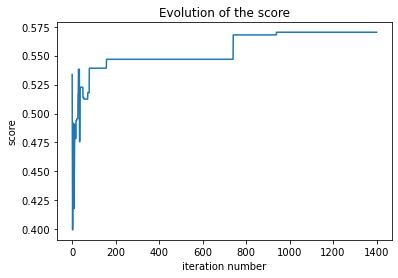

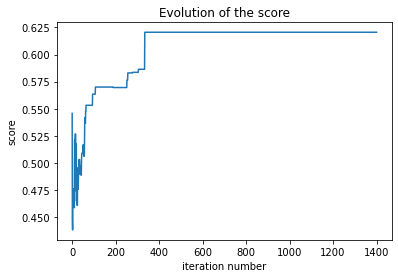

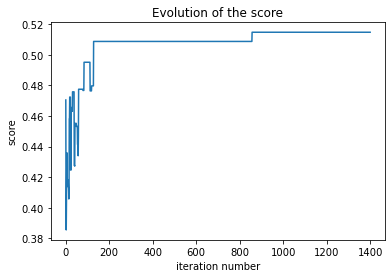

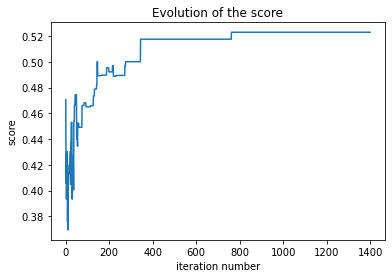

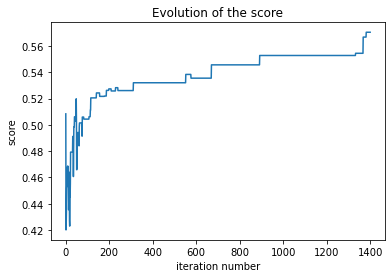

test 0.5541365832235396 0.07974733751701092
TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR =  (194.0, 237.0, 0.8185654008438819, 0.749034749034749, 0.9823647592826847, 0.45011600928074247, 0.9951006256124219, 0.5498839907192575, 0.25096525096525096)


In [9]:
#Define parameters for MI + stimulated annealing method
N = np.array([700])
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_iter': 1400, 'n_neighbors': 3, 'p_mutate': 0.1, 'c': 1, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE3, FamiliesClusters, compute_precision,True, 5,  MI_stimulated_annealing, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE3[:, subset]
pred = model.fit_predict(x_subset,y)

print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred)) 

# Mutual information and genetic feature selection

In [10]:
#Define parameters for MI + genetic algorithm method
N = np.array([700])                            
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'n_population': 300, 'crossover_proba': 0.5, 'mutation_proba': 0.2, 'n_generations': 120, 'tournament_size': 3, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE3, FamiliesClusters, compute_precision,True, 5,  MI_genetic_fs, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE3[:, subset]
pred = model.fit_predict(x_subset,y)

print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred)) 

KeyboardInterrupt: 